# 🏀 XGBoost Model for March Madness Predictions

This notebook implements an XGBoost model for predicting NCAA March Madness tournament outcomes. It includes feature selection, hyperparameter tuning, and model calibration to optimize predictive performance.

In [1]:
# --------------------------------------------- Imports and Configurations ---------------------------------------------
import os
import sys
import gc
import warnings
from itertools import product
from pathlib import Path
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss, brier_score_loss
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

if os.path.exists('/kaggle/input'):
    sys.path.append('/kaggle/input/preprocessing-module')
else:
    sys.path.append('../../scripts')

from pre_processing import build_model_pipeline, rolling_window_cv, generate_matchup_matrix

warnings.filterwarnings("ignore")

# Set pandas options to display all columns.
pd.set_option("display.max_column", 999)


## 1. Model Setup and Data Preparation

We'll load the tournament data and prepare it for our XGBoost model using a custom pipeline.

In [2]:
tourney_data, y, game_ids = build_model_pipeline(model_type='xgb')
features = tourney_data.columns
print(tourney_data.head())

features = [col for col in tourney_data.columns if col != 'Season']
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label=y)

   Season   Team1FGM   Team1FGA  Team1FGM3  Team1FGA3    Team1OR   Team1Ast  \
0    2003  24.379310  56.793103   6.482759  18.000000  12.275862  13.034483   
1    2003  30.321429  65.714286   7.035714  20.071429  15.178571  17.642857   
2    2003  27.206897  56.896552   4.000000  12.586207  13.689655  15.551724   
3    2003  26.620690  52.689655   6.827586  17.931034  10.586207  15.620690   
4    2003  27.344828  58.724138   6.413793  17.034483  11.241379  16.000000   

     Team1TO  Team1Stl    Team1PF  Team2_opponent_FGM  Team2_opponent_FGA  \
0  16.206897  7.068966  19.103448           25.666667           60.400000   
1  14.785714  8.464286  17.750000           22.758621           55.068966   
2  14.000000  5.206897  19.413793           23.275862           57.862069   
3  18.241379  7.103448  20.965517           23.878788           55.333333   
4  14.172414  6.551724  17.103448           23.433333           53.133333   

   Team2_opponent_FGM3  Team2_opponent_FGA3  Team2_opponent_OR

## 2. Feature Engineering and Selection

In this section, we'll perform feature analysis and selection using SHAP values to understand feature importance and identify the most predictive variables while removing highly correlated features.

In [3]:
# --------------------------------------------- XGBoost Parameters (Classification) ---------------------------------------------
param = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'gbtree',
    'eta': 0.05,  
    'subsample': 0.35,
    'colsample_bytree': 0.7,
    'num_parallel_tree': 3,  
    'min_child_weight': 40,
    'gamma': 10,
    'max_depth': 3,
    'verbosity': 0
}
print("XGBoost parameters (classification):", param)

XGBoost parameters (classification): {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'verbosity': 0}


In [4]:
def brier_score(preds, dtrain):
    labels = dtrain.get_label()
    if preds.min() < 0 or preds.max() > 1:
        preds = 1.0 / (1.0 + np.exp(-preds))
    score = np.mean((preds - labels) ** 2)
    return 'brier_score', score

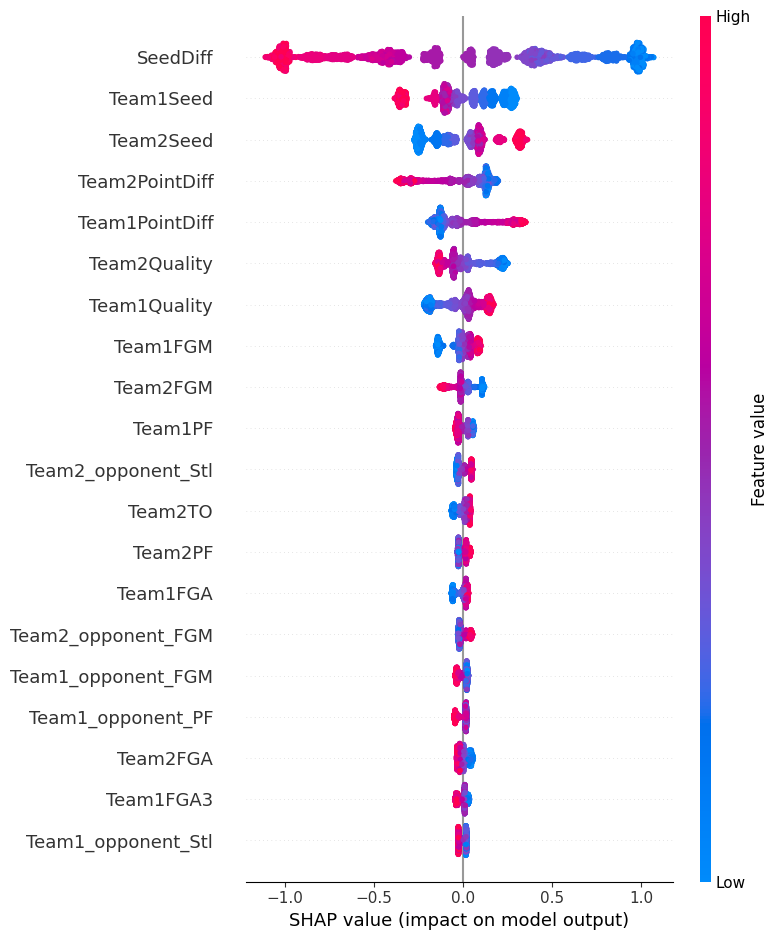

Selected Top 10 Features (with corr < 0.85):
SeedDiff: 0.587624
Team1Seed: 0.174508
Team2Seed: 0.166392
Team2PointDiff: 0.143315
Team1PointDiff: 0.139749
Team2Quality: 0.095355
Team1Quality: 0.093848
Team1FGM: 0.053011
Team2FGM: 0.046961
Team1PF: 0.031716


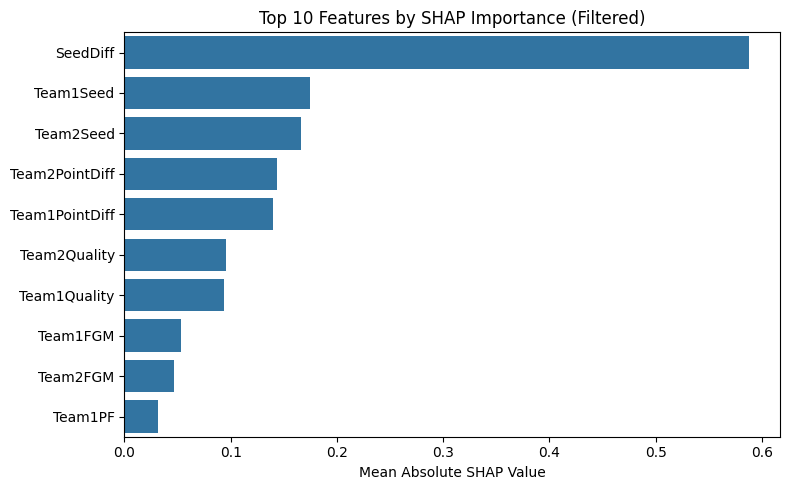

In [5]:
# --------------------------------------------------
# Ensure use of the full feature matrix corresponding to the complete list "features"
# --------------------------------------------------
if X.shape[1] != len(features):
    X_all = tourney_data.values
else:
    X_all = X

df_X = pd.DataFrame(X_all, columns=features)

# ----------------------------------------------------------------------
# Feature importance analysis with SHAP
# ----------------------------------------------------------------------
# Step 1: Train a baseline model (use more rounds for stability)
baseline_model = xgb.train(param, dtrain, num_boost_round=200)  # Increased rounds for better convergence

# Step 2: Compute SHAP values (using DataFrame with named columns)
explainer = shap.TreeExplainer(baseline_model)
shap_values = explainer.shap_values(df_X)

# SHAP summary plot to visualize overall feature impact
shap.summary_plot(shap_values, df_X)

# Step 3: Rank features by mean absolute SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance = dict(zip(features, mean_abs_shap))
sorted_features = sorted(feature_importance, key=feature_importance.get, reverse=True)

# Step 4: Compute correlation matrix for all features
corr_matrix = df_X.corr().abs()

# Step 5: Filter out highly correlated features
correlation_threshold = 0.85  
selected_features = []
for feat in sorted_features:
    if all(corr_matrix.loc[feat, sel_feat] < correlation_threshold for sel_feat in selected_features):
        selected_features.append(feat)
    if len(selected_features) >= 10:
        break

top10_features = selected_features

print(f"Selected Top 10 Features (with corr < {correlation_threshold:.2f}):")
for feat in top10_features:
    print(f"{feat}: {feature_importance[feat]:.6f}")

# Step 6: Visualize SHAP values for Top 10 Features
importance_values = [feature_importance[feat] for feat in top10_features]
plt.figure(figsize=(8, 5))
sns.barplot(x=importance_values, y=top10_features, orient="h")
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Top 10 Features by SHAP Importance (Filtered)")
plt.tight_layout()
plt.show()

In [6]:
def xgb_model_fn(X_train, y_train, X_test, y_test, test_season, model_params=None, sample_weight=None, include_best_iteration=False, num_boost_round=3000, early_stopping_rounds=25):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    evals_result = {}
    model = xgb.train(
        params=model_params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        early_stopping_rounds=early_stopping_rounds,
        evals=[(dtest, 'eval')],
        evals_result=evals_result,
        verbose_eval=False
    )
    
    preds = model.predict(dtest)
    brier = np.mean((preds - y_test) ** 2)
    logloss = np.mean(-y_test * np.log(preds) - (1 - y_test) * np.log(1 - preds))
    accuracy = np.mean((preds > 0.5) == y_test)
    
    metrics = {
        'accuracy': accuracy,
        'logloss': logloss,
        'brier': brier
    }
    
    # Include best_iteration in metrics if requested
    if include_best_iteration:
        metrics['best_iteration'] = model.best_iteration
    
    return metrics

In [7]:
start_season = 2010

In [8]:
# -------------------------------------------------------------
# Forward feature selection with pair, "remove-and-pair", triple look-ahead
# -------------------------------------------------------------
tol          = 1e-5
K_PAIRS      = 6       # top-K singles to combine into pairs

def evaluate_subset(feats, param, start_season=start_season):
    """Return mean Brier score for a feature subset via rolling CV."""
    if 'Season' not in feats:
        feats = ['Season'] + feats
    cv = rolling_window_cv(
        X=tourney_data[feats].copy(),
        y=y,
        start_season=start_season,
        window_size=None,
        model_fn=xgb_model_fn,
        model_params=param,
        sample_weight_fn=None,
        verbose=False,
    )
    return cv['brier'].mean() if not cv.empty else np.inf

print("Forward selection with multi-step look-ahead")

# Initialize ---------------------------------------------------
selected      = top10_features.copy()
remaining     = [f for f in features if f not in selected]
current_brier = evaluate_subset(selected, param)
print(f"Initial 10-feature Brier = {current_brier:.6f}")

last_single_added = None     # tracks last feature added by Step-1

# Main loop ----------------------------------------------------
improved = True
while remaining and improved:
    improved = False

    # ---------------------------------------------------------
    # 1) SINGLE-FEATURE SCAN  
    # ---------------------------------------------------------
    single_scores = []
    for feat in remaining:
        b = evaluate_subset(selected + [feat], param)
        single_scores.append((feat, b))
        print(f" {feat:<25} → Brier {b:.6f}")

    best_feat, best_brier = min(single_scores, key=lambda x: x[1])

    if best_brier < current_brier - tol:
        selected.append(best_feat)
        remaining.remove(best_feat)
        current_brier     = best_brier
        last_single_added = best_feat
        improved          = True
        print(f"Added {best_feat:<25} → New Brier {current_brier:.6f}")
        continue

    # ---------------------------------------------------------
    # 2) LOOK-AHEAD WITH SEVERAL 2-FEATURE COMBINATIONS
    # ---------------------------------------------------------
    single_scores.sort(key=lambda x: x[1])          # best singles first
    top_k = single_scores[:min(K_PAIRS, len(single_scores))]

    best_pair        = None
    best_pair_brier  = current_brier
    for i in range(len(top_k)):
        f1 = top_k[i][0]
        for j in range(i + 1, len(top_k)):
            f2 = top_k[j][0]
            b = evaluate_subset(selected + [f1, f2], param)
            print(f" Testing pair ({f1}, {f2}) → Brier {b:.6f}")
            if b < best_pair_brier - tol:
                best_pair_brier = b
                best_pair       = (f1, f2)

    if best_pair is not None:
        selected.extend(best_pair)
        for f in best_pair:
            remaining.remove(f)
        current_brier     = best_pair_brier
        last_single_added = None           # we added two at once
        improved          = True
        print(f"Added pair {best_pair} → New Brier {current_brier:.6f}")
        continue

    # ---------------------------------------------------------
    # 2.5) "REMOVE-AND-PAIR" LOOK-AHEAD  
    # ---------------------------------------------------------
    if last_single_added is not None:
        print(f"Trying to replace last single '{last_single_added}' with a better pair...")
        # create candidate subset WITHOUT that last single
        candidate_selected = [f for f in selected if f != last_single_added]
        # candidate remaining list: current remaining + the dropped feature
        candidate_remaining = remaining + [last_single_added]

        # recompute single scores for candidate_remaining
        cand_single_scores = []
        for feat in candidate_remaining:
            b = evaluate_subset(candidate_selected + [feat], param)
            cand_single_scores.append((feat, b))
        cand_single_scores.sort(key=lambda x: x[1])
        top_k_cand = cand_single_scores[:min(K_PAIRS, len(cand_single_scores))]

        best_pair2        = None
        best_pair2_brier  = current_brier
        for i in range(len(top_k_cand)):
            f1 = top_k_cand[i][0]
            if f1 == last_single_added:
                continue
            for j in range(i + 1, len(top_k_cand)):
                f2 = top_k_cand[j][0]
                if f2 == last_single_added:
                    continue
                b = evaluate_subset(candidate_selected + [f1, f2], param)
                print(f" Replace-pair ({f1}, {f2}) → Brier {b:.6f}")
                if b < best_pair2_brier - tol:
                    best_pair2_brier = b
                    best_pair2       = (f1, f2)

        if best_pair2 is not None:
            selected = candidate_selected + list(best_pair2)
            remaining = [f for f in candidate_remaining if f not in best_pair2]
            current_brier     = best_pair2_brier
            last_single_added = None   
            improved          = True
            print(f" Replaced '{last_single_added}' with pair {best_pair2} "
                  f"→ New Brier {current_brier:.6f}")
            continue

    # ---------------------------------------------------------
    # 3) LOOK-AHEAD WITH BEST 3 FEATURES  
    # ---------------------------------------------------------
    if len(single_scores) >= 3:
        triple = [single_scores[i][0] for i in range(3)]
        triple_brier = evaluate_subset(selected + triple, param)
        print(f" Testing best-3 {triple} → Brier {triple_brier:.6f}")
        if triple_brier < current_brier - tol:
            selected.extend(triple)
            for f in triple:
                remaining.remove(f)
            current_brier     = triple_brier
            last_single_added = None     
            improved          = True
            print(f" Added triple {tuple(triple)} → New Brier {current_brier:.6f}")

# Summary ------------------------------------------------------
print("\nSelection complete")
print(f"Final features ({len(selected)}): {selected}")
print(f"Final CV-Brier: {current_brier:.6f}")


Forward selection with multi-step look-ahead
Initial 10-feature Brier = 0.180166
 Team1FGA                  → Brier 0.180007
 Team1FGM3                 → Brier 0.180115
 Team1FGA3                 → Brier 0.179991
 Team1OR                   → Brier 0.179990
 Team1Ast                  → Brier 0.180053
 Team1TO                   → Brier 0.180031
 Team1Stl                  → Brier 0.180030
 Team2_opponent_FGM        → Brier 0.179854
 Team2_opponent_FGA        → Brier 0.180005
 Team2_opponent_FGM3       → Brier 0.180018
 Team2_opponent_FGA3       → Brier 0.180049
 Team2_opponent_OR         → Brier 0.179997
 Team2_opponent_Ast        → Brier 0.179925
 Team2_opponent_TO         → Brier 0.179986
 Team2_opponent_Stl        → Brier 0.180062
 Team2_opponent_PF         → Brier 0.180015
 Team2FGA                  → Brier 0.180037
 Team2FGM3                 → Brier 0.179961
 Team2FGA3                 → Brier 0.180005
 Team2OR                   → Brier 0.179999
 Team2Ast                  → Brier 0.17

## 3. Hyperparameter Tuning

In this section, we'll perform grid search to find the optimal hyperparameters for our XGBoost model. We'll evaluate various combinations of learning rate, tree depth, regularization parameters, and sampling rates to find the configuration that minimizes prediction error.

In [9]:
# --------------------------------------------- Custom Cross-Validation Function ---------------------------------------------
def custom_cv(params, X, y, num_boost_round=3000, early_stopping_rounds=25, feval=None):
    """
    wrapper for rolling_window_cv
    """
    from pre_processing import rolling_window_cv
    
    if isinstance(X, np.ndarray):
        X_df = pd.DataFrame(X, columns=selected)
        if 'Season' not in X_df.columns:
            X_df['Season'] = tourney_data['Season'].values
    else:
        X_df = X.copy()
        if 'Season' not in X_df.columns:
            X_df['Season'] = tourney_data['Season'].values
    
    # Run rolling window cross-validation with include_best_iteration=True
    metrics_df = rolling_window_cv(
        X=X_df,
        y=y,
        start_season=start_season,  
        window_size=None,   
        model_fn=lambda X_train, y_train, X_test, y_test, test_season, model_params, sample_weight: 
               xgb_model_fn(X_train, y_train, X_test, y_test, test_season, model_params, sample_weight, 
                           include_best_iteration=True, num_boost_round=num_boost_round, 
                           early_stopping_rounds=early_stopping_rounds),
        model_params=params,
        sample_weight_fn=None,
        verbose=False
    )
    
    # Calculate averages across test seasons
    if not metrics_df.empty:
        avg_best_iteration = int(metrics_df['best_iteration'].mean())
        avg_logloss = metrics_df['logloss'].mean()
        avg_brier = metrics_df['brier'].mean()
        return avg_best_iteration, avg_logloss, avg_brier
    else:
        return 100, 1.0, 0.5

0       1
1       1
2       1
3       1
4       1
       ..
4279    0
4280    0
4281    0
4282    0
4283    0
Name: Team1Wins, Length: 4284, dtype: int64
Testing parameters: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'booster': 'gbtree', 'eta': 0.065, 'subsample': 0.5, 'colsample_bytree': 0.8, 'num_parallel_tree': 3, 'min_child_weight': 30, 'gamma': 10, 'max_depth': 4, 'verbosity': 0}
Best iteration: 181 Logloss: 0.5236922708184936 Brier score: 0.17616710379708417
Testing parameters: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'booster': 'gbtree', 'eta': 0.065, 'subsample': 0.5, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 30, 'gamma': 10, 'max_depth': 4, 'verbosity': 0}
Best iteration: 197 Logloss: 0.52418830596196 Brier score: 0.1763299667219908
Testing parameters: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'booster': 'gbtree', 'eta': 0.065, 'subsample': 0.35, 'colsample_bytree': 0.8, 'num_parallel_tree': 3, 'min_

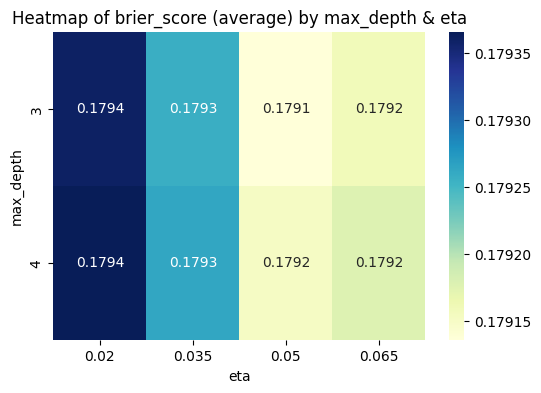


Top 10 parameter combos sorted by brier_score:
       eta  max_depth  min_child_weight  gamma  subsample  colsample_bytree  \
16   0.065          3                30     10        0.5               0.8   
32   0.050          4                30     10        0.5               0.8   
48   0.050          3                30     10        0.5               0.8   
112  0.020          3                30     10        0.5               0.8   
0    0.065          4                30     10        0.5               0.8   
80   0.035          3                30     10        0.5               0.8   
96   0.020          4                30     10        0.5               0.8   
64   0.035          4                30     10        0.5               0.8   
113  0.020          3                30     10        0.5               0.7   
97   0.020          4                30     10        0.5               0.7   

     best_iteration   logloss  brier_score  
16              205  0.523280     0.1

In [10]:
# --------------------------------------------- Hyperparameter Tuning ---------------------------------------------
def tune_hyperparameters(X, y, base_params, param_grid, num_boost_round=3000, early_stopping_rounds=25):
    """
    Performs grid search over hyperparameters using custom cross-validation.
    Returns a list of tuples: (current_params, best_iteration, best_logloss, best_brier).
    """
    tuning_results = []
    keys = list(param_grid.keys())
    
    # Generate all combinations of hyperparameters
    for values in product(*[param_grid[k] for k in keys]):
        current_params = base_params.copy()
        for key, value in zip(keys, values):
            current_params[key] = value
        print("Testing parameters:", current_params)
        
        # Use custom_cv to evaluate current parameters
        best_iteration, best_logloss, best_brier = custom_cv(
            current_params,
            X,
            y,
            num_boost_round=num_boost_round,
            early_stopping_rounds=early_stopping_rounds,
            feval=None
        )
        
        print("Best iteration:", best_iteration, "Logloss:", best_logloss, "Brier score:", best_brier)
        tuning_results.append((current_params.copy(), best_iteration, best_logloss, best_brier))
    
    return tuning_results

# Use the selected features for tuning.
X_subset = tourney_data[selected].values

param_grid = {
    'eta': [0.065,0.05,0.035,0.02],
    'max_depth': [4,3],
    'min_child_weight': [30,40],
    'gamma': [10,20],
    'subsample': [0.5,0.35],
    'colsample_bytree': [0.8,0.7]
}

print(y)

tuning_results = tune_hyperparameters(X_subset, y, param, param_grid)

# Convert tuning results to DataFrame.
tuning_df = pd.DataFrame([{
    'eta': res[0]['eta'],
    'max_depth': res[0]['max_depth'],
    'min_child_weight': res[0]['min_child_weight'],
    'gamma': res[0]['gamma'],
    'subsample': res[0]['subsample'],
    'colsample_bytree': res[0]['colsample_bytree'],
    'best_iteration': res[1],
    'logloss': res[2],
    'brier_score': res[3]
} for res in tuning_results])
print("Tuning results (raw):")
print(tuning_df)

# Create a pivot table for two parameters (e.g., max_depth vs. eta),
# aggregating the average Brier score across other params.
pivot_df = tuning_df.groupby(['max_depth','eta'])['brier_score'].mean().unstack()
print("\nPivot table (avg logloss) by max_depth, eta:\n", pivot_df)

plt.figure(figsize=(6,4))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt=".4f")
plt.title("Heatmap of brier_score (average) by max_depth & eta")
plt.show()

# Show top 10 combos in a numeric table.
sorted_tuning_df = tuning_df.sort_values('brier_score', ascending=True)
top_n = 10
print(f"\nTop {top_n} parameter combos sorted by brier_score:")
print(sorted_tuning_df.head(top_n))

# Select best hyperparameters (lowest Brier score).
best_params, best_iter, best_logloss, best_brier = min(tuning_results, key=lambda x: x[3])
print("\nBest hyperparameters:", best_params)
print("Best iteration:", best_iter, "Best logloss:", best_logloss, "Best Brier score:", best_brier)

# Update the parameter dictionary to use the best hyperparameters.
param = best_params.copy()
tuning_df = pd.DataFrame([{
    'eta': res[0]['eta'],
    'max_depth': res[0]['max_depth'],
    'min_child_weight': res[0]['min_child_weight'],
    'gamma': res[0]['gamma'],
    'subsample': res[0]['subsample'],
    'colsample_bytree': res[0]['colsample_bytree'],
    'best_iteration': res[1],
    'logloss': res[2],
    'brier_score': res[3]
} for res in tuning_results])
print("Tuning results (raw):")
print(tuning_df)

## 4. Out-of-Fold Predictions and Model Validation

In this section, we'll generate out-of-fold (OOF) predictions to assess our model's performance across different tournament seasons. This approach mimics the real-world scenario where we train on historical data and predict future tournaments.

In [11]:
from pre_processing import rolling_window_cv
# --------------------------------------------- Out-of-Fold Predictions (Classification) ---------------------------------------------
def generate_oof_predictions(X, y, seasons, param,
                             num_boost_round=3000, start_season=start_season):
    """
    Train on seasons ≤ S and predict season S+1 for every S ≥ start_season.

    Returns
    -------
    oof_preds : ndarray of float, shape (len(y),)
        Probabilities for test seasons; NaN for rows that were never predicted.
    """
    # ---------------------- ensuring Season column --------------------------
    if isinstance(X, np.ndarray):
        X_df = pd.DataFrame(X)
    else:
        X_df = X.copy()

    if 'Season' not in X_df.columns:
        X_df['Season'] = seasons

    oof_preds = np.full_like(y, np.nan, dtype=float) # 0 -> nan    

    # ---------------------- model wrapper ---------------------------------
    def model_fn(X_tr, y_tr, X_te, y_te, test_season,
                 model_params, sample_weight=None):

        dtrain = xgb.DMatrix(X_tr, label=y_tr, weight=sample_weight)
        dtest  = xgb.DMatrix(X_te, label=y_te)

        model = xgb.train(
            params=model_params,
            dtrain=dtrain,
            num_boost_round=best_iter,
            early_stopping_rounds=25,
            evals=[(dtest, 'eval')],
            verbose_eval=False
        )

        preds = model.predict(dtest)
        return {
            'accuracy': np.mean((preds > 0.5) == y_te),
            'logloss':  np.mean(
                -y_te * np.log(preds) - (1 - y_te) * np.log(1 - preds)
            ),
            'brier':    np.mean((preds - y_te) ** 2),
            'predictions': preds,
            'test_season': test_season,
        }

    # ---------------------- rolling window CV -----------------------------
    metrics = rolling_window_cv(
        X=X_df, y=y, start_season=start_season,
        window_size=None,
        model_fn=model_fn, model_params=param,
        sample_weight_fn=None, verbose=False,
        return_preds=True
    )

    # ---------------------- insert predictions ----------------------------
    for _, row in metrics.iterrows():
        idx = np.where(seasons == row['test_season'])[0]
        oof_preds[idx] = row['predictions']

    return oof_preds



# Get seasons from tourney_data
seasons = tourney_data['Season'].values

# --- Experiment 1: Using All Features ---
X_all = tourney_data.values
oof_preds_all = generate_oof_predictions(X_all, y, seasons, param, num_boost_round=best_iter, start_season=start_season)

# --- Experiment 2: Using Selected Features ---
X_selected = tourney_data[selected].values
oof_preds_selected = generate_oof_predictions(X_selected, y, seasons, param, num_boost_round=best_iter, start_season=start_season)

# Function to evaluate OOF predictions using the Brier score
def evaluate_oof(oof_preds, y_true):
    return np.mean((oof_preds - y_true) ** 2)

mask = seasons >= (start_season + 1) 
brier_all = evaluate_oof(oof_preds_all[mask], y[mask])
brier_selected = evaluate_oof(oof_preds_selected[mask], y[mask])

print("Brier score using all features:", brier_all)
print("Brier score using selected features:", brier_selected)

Brier score using all features: 0.17667156879574156
Brier score using selected features: 0.17631783777326873


## 5. Model Calibration Analysis

In this section, we'll analyze how well our probability predictions match actual outcomes. A well-calibrated model should have predicted probabilities that match observed frequencies (e.g., events predicted with 70% probability should occur 70% of the time).

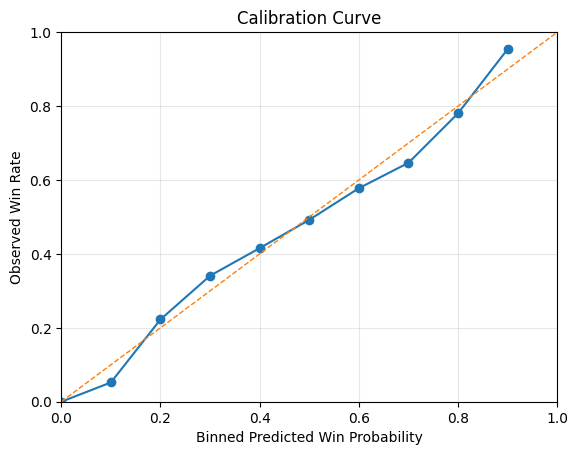

In [12]:
# --------------------------------------------------------------------------
# Calibration Curve Analysis - works only on seasons that were really predicted
# --------------------------------------------------------------------------
def plot_calibration_curve(oof_pred, y_true, bins=10):
    """
    Draw a reliability / calibration curve.

    Parameters
    ----------
    oof_pred : array-like
        Out-of-fold probabilities; rows without predictions must be NaN.
    y_true : array-like
        Ground-truth labels (same length as oof_pred).
    bins : int, optional
        How many equally spaced probability bins to use (default 10,
        i.e. 0.0-0.1, 0.1-0.2, …).
    """
    # Keep only rows that really have predictions
    mask = ~np.isnan(oof_pred)
    if mask.sum() == 0:
        raise ValueError("No valid predictions in oof_pred – nothing to plot.")

    df = pd.DataFrame({
        "pred":  oof_pred[mask],
        "label": y_true[mask]
    })

    # Bin and aggregate predictions
    df["pred_bin"] = (df["pred"] * bins).round() / bins
    cal = (
        df.groupby("pred_bin", as_index=False)["label"]
          .mean()
          .rename(columns={"label": "observed_win_rate"})
    )

    # Plot calibration curve
    plt.figure()
    plt.plot(cal.pred_bin, cal.observed_win_rate, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)      # perfect line
    plt.title("Calibration Curve")
    plt.xlabel("Binned Predicted Win Probability")
    plt.ylabel("Observed Win Rate")
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.show()
plot_calibration_curve(oof_preds_selected, y)


## 6. Advanced Calibration Techniques

In this section, we'll explore more sophisticated calibration methods including Isotonic Regression and Platt Scaling to improve our probability estimates. We'll compare these methods against our raw predictions to determine the optimal approach.

Raw   Brier: 0.1763   | log-loss: 0.5243
Iso   Brier: 0.1778   | log-loss: 0.5465
Platt Brier: 0.1788   | log-loss: 0.5337


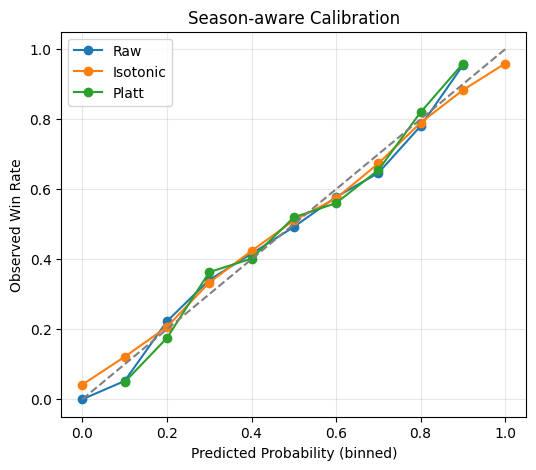

In [13]:
# ------------------------------------------------------------
#  Time Series Calibration Methods
# ------------------------------------------------------------
def time_series_isotonic(oof_pred, y_true, seasons, start_season=start_season+1):
    pred, true, seas = map(np.asarray, (oof_pred, y_true, seasons))
    calibrated = pred.copy()
    for s in np.sort(np.unique(seas)):
        if s < start_season:
            continue
        test  = (seas == s) & ~np.isnan(pred)
        train = (seas <  s) & ~np.isnan(pred)
        if train.sum() == 0:       # nothing to fit
            continue
        iso = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
        iso.fit(pred[train], true[train])
        if test.sum() == 0:        # nothing to transform
            continue
        calibrated[test] = iso.transform(pred[test])
    return calibrated


def time_series_platt(oof_pred, y_true, seasons, start_season=start_season+1):
    pred, true, seas = map(np.asarray, (oof_pred, y_true, seasons))
    calibrated = pred.copy()
    for s in np.sort(np.unique(seas)):
        if s < start_season:
            continue
        test  = (seas == s) & ~np.isnan(pred)
        train = (seas <  s) & ~np.isnan(pred)
        if train.sum() < 10 or test.sum() == 0:   # need data for both
            continue
        lr = LogisticRegression(solver='lbfgs')
        lr.fit(pred[train].reshape(-1, 1), true[train])
        calibrated[test] = lr.predict_proba(pred[test].reshape(-1, 1))[:, 1]
    return calibrated

# ------------------------------------------------------------
#  Metric helpers & plotting
# ------------------------------------------------------------
def _mask(arr):
    m = ~np.isnan(arr)
    return m, arr[m]

def brier(pred, y_true):
    m, p = _mask(pred)
    return brier_score_loss(y_true[m], p)

def lloss(pred, y_true):
    m, p = _mask(pred)
    p = np.clip(p, 1e-6, 1-1e-6)
    return log_loss(y_true[m], p)

def plot_reliability(pred, y_true, label, bins=10):
    m, p = _mask(pred)
    df = pd.DataFrame({"pred": p, "label": y_true[m]})
    df["bin"] = (df.pred * bins).round() / bins
    grp = df.groupby("bin", as_index=False)["label"].mean()
    plt.plot(grp.bin, grp.label, marker='o', label=label)


# ------------------------------------------------------------
# Run calibration pipeline
# ------------------------------------------------------------
oof = generate_oof_predictions(
    X_selected, y, seasons, param,
    num_boost_round=best_iter, start_season=start_season)

iso  = time_series_isotonic(oof, y, seasons, start_season=start_season+1)
platt = time_series_platt(oof, y, seasons, start_season=start_season+1)

print(f"Raw   Brier: {brier(oof,   y):.4f}   | log-loss: {lloss(oof,   y):.4f}")
print(f"Iso   Brier: {brier(iso,   y):.4f}   | log-loss: {lloss(iso,   y):.4f}")
print(f"Platt Brier: {brier(platt, y):.4f}   | log-loss: {lloss(platt, y):.4f}")

plt.figure(figsize=(6,5))
plot_reliability(oof,   y, "Raw")
plot_reliability(iso,   y, "Isotonic")
plot_reliability(platt, y, "Platt")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("Season-aware Calibration")
plt.xlabel("Predicted Probability (binned)")
plt.ylabel("Observed Win Rate")
plt.legend(); plt.grid(alpha=.3); plt.show()


## 7. Final Evaluation and Results Summary

In this section, we'll compare model performance across different tournament seasons using Log Loss, Accuracy, and Brier Score metrics. We'll evaluate both the full-feature model and our feature-selected model to determine which approach produces the best predictions.

In [14]:
# =============================================================
# FINAL EVALUATION - Season-aware, with optional calibration
# =============================================================

# -----------------------------------------------------------------
# 1) Raw out-of-fold probabilities from rolling-window CV
# -----------------------------------------------------------------
oof_all = generate_oof_predictions(
    X_all, y, seasons, param,
    num_boost_round=best_iter, start_season=start_season
)

oof_sel = generate_oof_predictions(
    X_selected, y, seasons, param,
    num_boost_round=best_iter, start_season=start_season
)

# -----------------------------------------------------------------
# 2) Choose calibration method: 'raw' | 'isotonic' | 'platt'
# -----------------------------------------------------------------
CALIB_METHOD = 'raw'        # <-- set calibration method here

calibrators = {
    'raw':      lambda p: p,
    'isotonic': lambda p: time_series_isotonic(p, y, seasons,
                                             start_season=start_season),
    'platt':    lambda p: time_series_platt(p, y, seasons,
                                          start_season=start_season)
}

cal_all = calibrators[CALIB_METHOD](oof_all)
cal_sel = calibrators[CALIB_METHOD](oof_sel)

# -----------------------------------------------------------------
# 3) Metric helpers
# -----------------------------------------------------------------
def logloss(pred, y_true):
    m, p = _mask(pred)
    p = np.clip(p, 1e-6, 1-1e-6)
    return log_loss(y_true[m], p)

def accuracy(pred, y_true):
    m, p = _mask(pred)
    return np.mean((p >= 0.5) == y_true[m])

def season_metrics(pred, y_true, seasons):
    rows = []
    for s in np.sort(np.unique(seasons)):
        idx = (seasons == s) & ~np.isnan(pred)
        if idx.sum() == 0:
            continue
        rows.append({
            "Season":   s,
            "LogLoss":  logloss(pred[idx], y_true[idx]),
            "Accuracy": accuracy(pred[idx], y_true[idx]),
            "Brier":    brier(pred[idx], y_true[idx])
        })
    return pd.DataFrame(rows).set_index("Season")

def evaluate(pred, y_true, seasons, label):
    per_season = season_metrics(pred, y_true, seasons)
    overall = per_season.mean()
    print(f"\n===== {label} ({CALIB_METHOD}) =====")
    print(per_season)
    print("\nOverall averages")
    print(overall)
    return per_season, overall

# -----------------------------------------------------------------
# 4) Run evaluation for both feature sets
# -----------------------------------------------------------------
_, _ = evaluate(cal_all, y, seasons, "ALL FEATURES")
_, _ = evaluate(cal_sel, y, seasons, "SELECTED FEATURES")



===== ALL FEATURES (raw) =====
         LogLoss  Accuracy     Brier
Season                              
2011    0.561520  0.684615  0.190514
2012    0.510857  0.780769  0.167558
2013    0.559007  0.696154  0.191053
2014    0.559387  0.719231  0.191739
2015    0.466804  0.826923  0.150042
2016    0.548752  0.692308  0.186947
2017    0.489833  0.765385  0.162588
2018    0.537339  0.700000  0.181915
2019    0.461699  0.723077  0.152880
2021    0.556018  0.709302  0.191594

Overall averages
LogLoss     0.525122
Accuracy    0.729776
Brier       0.176683
dtype: float64

===== SELECTED FEATURES (raw) =====
         LogLoss  Accuracy     Brier
Season                              
2011    0.562108  0.665385  0.190830
2012    0.510704  0.769231  0.167073
2013    0.555556  0.703846  0.190093
2014    0.556463  0.715385  0.190730
2015    0.468557  0.819231  0.151030
2016    0.546465  0.692308  0.185982
2017    0.488085  0.761538  0.162072
2018    0.537933  0.684615  0.182367
2019    0.460385  0.7

In [15]:
# ------------------------------------------------------------------
# 0)  Output directory for predictions
# ------------------------------------------------------------------
if os.path.exists("/kaggle/input"):
    preds_dir = Path("/kaggle/working/predictions")
else:
    preds_dir = Path(os.getcwd()).parent.parent / "preds"

preds_dir.mkdir(exist_ok=True, parents=True)
print(f"→ Predictions will be written to {preds_dir}")

# ------------------------------------------------------------------
# 1)  Model and data settings
# ------------------------------------------------------------------
xgb_features = selected               # final feature subset
xgb_params = param.copy()           # best hyper-parameters
xgb_params.setdefault("nthread", -1)  # use all cores
num_rounds = int(best_iter)         # best number of boosting rounds

# ------------------------------------------------------------------
# 2)  Train → predict loop for each season
# ------------------------------------------------------------------
for season in (2022, 2023, 2024):

    train_mask = tourney_data["Season"] < season

    X_train = tourney_data.loc[train_mask, xgb_features].values
    y_train = y.loc[train_mask].values

    # train XGBoost
    dtrain  = xgb.DMatrix(X_train, label=y_train)
    booster = xgb.train(params=xgb_params,
                        dtrain=dtrain,
                        num_boost_round=num_rounds)

    # generate and collect preds for M & W
    all_dfs = []
    for gender in ("M", "W"):
        X_pred_raw, game_ids = generate_matchup_matrix("xgb", season, gender=gender)
        X_pred = X_pred_raw[xgb_features].values
        dpred  = xgb.DMatrix(X_pred)
        y_hat  = booster.predict(dpred)

        all_dfs.append(pd.DataFrame({
            "Season":      season,
            "GameID":      game_ids,
            "y_hat_proba": y_hat,
        }))

    df_out = pd.concat(all_dfs, ignore_index=True)
    out_f  = preds_dir / f"predictions_{season}_xgb.csv"
    df_out.to_csv(out_f, index=False)

    n_train = train_mask.sum()
    print(f"{season}: trained on {n_train:>4} rows → "
          f"{len(df_out):>4} preds  |  saved → {out_f}")

→ Predictions will be written to /home/benc/projects/ML-final/preds
2022: trained on 3748 rows → 4556 preds  |  saved → /home/benc/projects/ML-final/preds/predictions_2022_xgb.csv
2023: trained on 4016 rows → 4556 preds  |  saved → /home/benc/projects/ML-final/preds/predictions_2023_xgb.csv
2024: trained on 4284 rows → 4556 preds  |  saved → /home/benc/projects/ML-final/preds/predictions_2024_xgb.csv
